# Classification Emergency Case

Kode ini digunakan untuk mengembangkan model klasifikasi teks untuk kasus darurat medis. Model ini menggunakan teknik deep learning dengan algoritma LSTM untuk menganalisis dan mengklasifikasikan teks berdasarkan kategori yang diberikan.

## 1. Import Package
Pada bagian ini, kita mengimpor berbagai library yang diperlukan untuk menyelesaikan proyek:
- Data Manipulation: pandas dan numpy untuk mengolah dan memanipulasi dataset.
- Text Preprocessing: nltk untuk tokenisasi dan stopwords, serta Sastrawi untuk stemming teks Bahasa Indonesia.
- Model Development: tensorflow untuk membangun dan melatih model deep learning.
- Visualization: matplotlib, seaborn untuk membuat grafik performa model.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import os
import re
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

2024-12-03 16:39:47.002122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 16:39:47.015402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733218787.032457 1024149 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733218787.036830 1024149 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 16:39:47.056507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 2. Preprocessing
Bagian ini adalah langkah awal untuk mempersiapkan data sebelum digunakan dalam pelatihan model. Berikut langkah-langkahnya:


### 2.1. Load Dataset


In [2]:
# Load Dataset
data = pd.read_csv('Dataset/Clean_emergency_case.csv')
print(data.head())

                                                Text Label
0  ada kecelakaan besar di jalan tol banyak korba...  High
1  orang ini pingsan dan tidak bernapas segera ki...  High
2           ada anak kecil tenggelam dia tidak sadar  High
3  kecelakaan sepeda motor dengan luka parah di k...  High
4  seorang pria terjatuh dari gedung tinggi seger...  High


### 2.2. Normalisasi Teks

In [3]:
# Mengubah teks menjadi huruf kecil
data['Text'] = data['Text'].str.lower()

# Menghapus tanda baca dan karakter non-alfabet
data['Text'] = data['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

print(data.head())

                                                Text Label
0  ada kecelakaan besar di jalan tol banyak korba...  High
1  orang ini pingsan dan tidak bernapas segera ki...  High
2           ada anak kecil tenggelam dia tidak sadar  High
3  kecelakaan sepeda motor dengan luka parah di k...  High
4  seorang pria terjatuh dari gedung tinggi seger...  High


### 2.3. Tokenization

In [4]:
nltk.download('punkt_tab')

# Tokenization teks
data['tokens'] = data['Text'].apply(word_tokenize)

print(data[['Text', 'tokens']].head())

                                                Text  \
0  ada kecelakaan besar di jalan tol banyak korba...   
1  orang ini pingsan dan tidak bernapas segera ki...   
2           ada anak kecil tenggelam dia tidak sadar   
3  kecelakaan sepeda motor dengan luka parah di k...   
4  seorang pria terjatuh dari gedung tinggi seger...   

                                              tokens  
0  [ada, kecelakaan, besar, di, jalan, tol, banya...  
1  [orang, ini, pingsan, dan, tidak, bernapas, se...  
2   [ada, anak, kecil, tenggelam, dia, tidak, sadar]  
3  [kecelakaan, sepeda, motor, dengan, luka, para...  
4  [seorang, pria, terjatuh, dari, gedung, tinggi...  


[nltk_data] Downloading package punkt_tab to /home/rafli/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 2.4. Stop Words


In [5]:
nltk.download('stopwords')

# Mengambil stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Menghapus kata-kata tertentu dari daftar stopwords
custom_stopwords = {"tidak", "kecil", "besar"}  # Kata-kata yang ingin dipertahankan
stop_words = stop_words - custom_stopwords  # Menghapus kata-kata tersebut dari stopwords

# Menghapus stopwords
data['tokens'] = data['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

print(data[['Text', 'tokens']].head())


[nltk_data] Downloading package stopwords to /home/rafli/nltk_data...


                                                Text  \
0  ada kecelakaan besar di jalan tol banyak korba...   
1  orang ini pingsan dan tidak bernapas segera ki...   
2           ada anak kecil tenggelam dia tidak sadar   
3  kecelakaan sepeda motor dengan luka parah di k...   
4  seorang pria terjatuh dari gedung tinggi seger...   

                                              tokens  
0   [kecelakaan, besar, jalan, tol, korban, terluka]  
1  [orang, pingsan, tidak, bernapas, kirim, ambul...  
2             [anak, kecil, tenggelam, tidak, sadar]  
3   [kecelakaan, sepeda, motor, luka, parah, kepala]  
4           [pria, terjatuh, gedung, kirim, bantuan]  


[nltk_data]   Package stopwords is already up-to-date!


### 2.5. Stemming

In [6]:
# Menginisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Melakukan stemming pada token
data['tokens'] = data['tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

# Menampilkan hasil
print(data[['tokens']]  )

                                                 tokens
0             [celaka, besar, jalan, tol, korban, luka]
1       [orang, pingsan, tidak, napas, kirim, ambulans]
2                [anak, kecil, tenggelam, tidak, sadar]
3          [celaka, sepeda, motor, luka, parah, kepala]
4                   [pria, jatuh, gedung, kirim, bantu]
...                                                 ...
1970                     [mual, makan, tidur, sebentar]
1971                  [pusing, diri, duduk, minum, air]
1972  [tolong, kaku, punggung, duduk, nggak, sakit, ...
1973        [anak, alergi, kena, dingin, hidung, meler]
1974         [tolong, pusing, ruang, duduk, minum, air]

[1975 rows x 1 columns]


In [7]:
# Menentukan panjang maksimum urutan dan dimensi embedding
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
VOCABULARY_SIZE = 10000


In [8]:
# Membuat tokenizer dan menyesuaikan dengan data teks yang ada
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tokens'])

In [9]:
# Mengonversi teks yang telah diproses menjadi urutan indeks berdasarkan tokenizer
sequences = tokenizer.texts_to_sequences(data['tokens'])

In [10]:
# Melakukan padding pada urutan agar panjangnya sama
X_padded = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
print("\nPadded Sequences Shape:", X_padded.shape)


Padded Sequences Shape: (1975, 100)


In [11]:
# Menggunakan LabelEncoder untuk mengubah label teks menjadi format numerik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Label'])

print("\nEncoded Labels:", y[:5])


Encoded Labels: [0 0 0 0 0]


In [12]:
# Membagi dataset menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain and Test Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Train and Test Shapes:
X_train: (1580, 100)
X_test: (395, 100)
y_train: (1580,)
y_test: (395,)


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/home/rafli/miniconda3/envs/instahelp/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1733218800.760633 1024149 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Menyusun model dengan optimizer Adam dan loss sparse_categorical_crossentropy
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# Menggunakan callback EarlyStopping untuk menghentikan pelatihan jika model tidak membaik
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

In [16]:
# Melatih model dengan data latih dan validasi
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100


I0000 00:00:1733218805.330279 1024261 cuda_dnn.cc:529] Loaded cuDNN version 90501


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 718ms/step - accuracy: 0.3411 - loss: 1.0982 - val_accuracy: 0.3892 - val_loss: 1.0927
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step - accuracy: 0.4101 - loss: 1.0890 - val_accuracy: 0.5253 - val_loss: 1.0760
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step - accuracy: 0.4870 - loss: 1.0712 - val_accuracy: 0.6139 - val_loss: 1.0423
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step - accuracy: 0.5577 - loss: 1.0257 - val_accuracy: 0.6108 - val_loss: 0.9571
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.6442 - loss: 0.9246 - val_accuracy: 0.6171 - val_loss: 0.8309
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.6697 - loss: 0.7787 - val_accuracy: 0.6741 - val_loss: 0.7219
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step - accuracy: 0.6741 - loss: 0.7140 - val_accuracy: 0.7025 - val_loss: 0.6429
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - accuracy: 0.7271 - loss: 0.6189 - val_accuracy: 0.7563 - val_loss: 0.5

In [17]:
# Mengevaluasi model pada data uji
loss, accuracy = model.evaluate(X_test, y_test)
print("\nTest Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8745 - loss: 0.3994

Test Loss: 0.38493937253952026
Test Accuracy: 0.8759493827819824


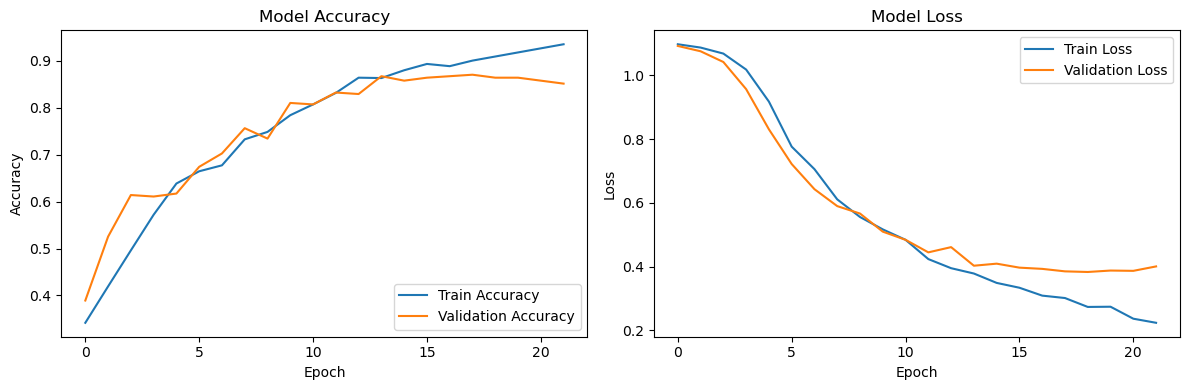

In [18]:
# Menampilkan grafik akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
# Menyimpan model, tokenizer, dan label encoder
model.save('emergency_case_model.h5')

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nModel, Tokenizer, and Label Encoder have been saved.")


Model, Tokenizer, and Label Encoder have been saved.


In [20]:
# Importing the necessary metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Menggunakan model untuk memprediksi label pada dataset
y_pred = model.predict(X_padded)
y_pred = np.argmax(y_pred, axis=1)  # Mengambil indeks dengan probabilitas tertinggi

# Menghitung metrik evaluasi
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# Menampilkan classification report
print("Classification Report:")
print(classification_report(y, y_pred))

# Menampilkan confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

# Menampilkan metrik individual
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       642
           1       0.89      0.92      0.90       695
           2       0.89      0.83      0.86       638

    accuracy                           0.91      1975
   macro avg       0.91      0.91      0.91      1975
weighted avg       0.91      0.91      0.91      1975


Confusion Matrix:
[[630   0  12]
 [  2 642  51]
 [ 29  82 527]]

Accuracy: 0.9108860759493671
Precision: 0.9104051548293837
Recall: 0.9108860759493671
F1-Score: 0.9100214422407554


In [22]:
def predict_emergency_case(text):
    # Preprocessing teks
    text = text.lower()  # Mengubah teks menjadi huruf kecil
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca dan karakter non-alfabet
    tokens = word_tokenize(text)  # Tokenisasi
    tokens = [word for word in tokens if word not in stop_words]  # Menghapus stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Mengonversi token menjadi urutan indeks
    sequence = tokenizer.texts_to_sequences([tokens])
    
    # Melakukan padding pada urutan
    padded = pad_sequences(sequence, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
    
    # Melakukan prediksi
    prediction = model.predict(padded)
    
    # Mengambil indeks label dengan probabilitas tertinggi
    predicted_index = np.argmax(prediction, axis=1)
    
    # Mengonversi indeks kembali ke label asli
    predicted_label = label_encoder.inverse_transform(predicted_index)
    
    return predicted_label[0]


In [23]:
# Contoh teks untuk diuji
sample_texts = [
    "Segera kirimkan ambulans, ada kecelakaan serius di jalan.",
    "Saya merasa pusing dan ingin berkonsultasi dengan dokter.",
    "Ingin tahu informasi jadwal ambulans terdekat."
]

# Melakukan prediksi pada setiap contoh teks
for text in sample_texts:
    label = predict_emergency_case(text)
    print(f"Text: {text}\nPredicted Label: {label}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Text: Segera kirimkan ambulans, ada kecelakaan serius di jalan.
Predicted Label: High

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Text: Saya merasa pusing dan ingin berkonsultasi dengan dokter.
Predicted Label: Low

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Text: Ingin tahu informasi jadwal ambulans terdekat.
Predicted Label: Low

